Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score

df=pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head(5)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df = df.replace('No',0)
df = df.replace("Yes",1)
df.head(5)

,Unnamed: 0,default,student,balance,income
0,1,0,0,729.526495,44361.625074
1,2,0,1,817.180407,12106.134700
2,3,0,0,1073.549164,31767.138947
3,4,0,0,529.250605,35704.493935
4,5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

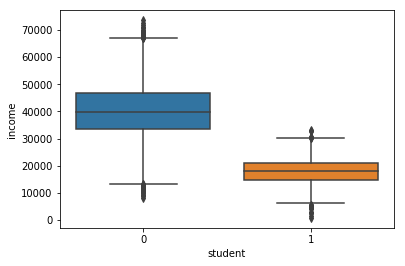

In [3]:
ax=sns.boxplot(x='student',y='income',data=df)
plt.show()

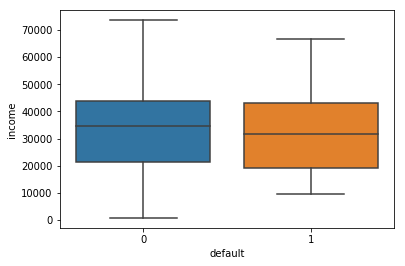

In [4]:
ax=sns.boxplot(x='default',y='income',data=df)
plt.show()

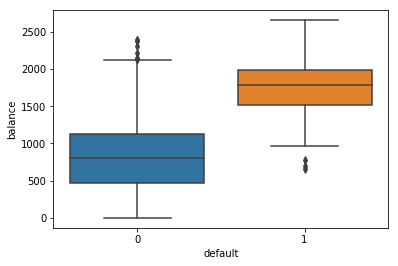

In [5]:
ax=sns.boxplot(x='default',y='balance',data=df)
plt.show()

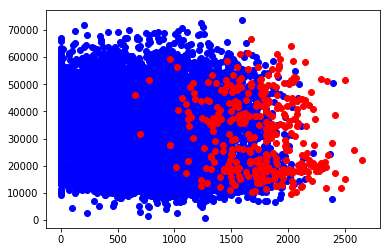

In [6]:
plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [7]:
sdf=df[df['student']==1] # should only be students
sdf.head(5)

,Unnamed: 0,default,student,balance,income
1,2,0,1,817.180407,12106.134700
5,6,0,1,919.588530,7491.558572
7,8,0,1,808.667504,17600.451344
10,11,0,1,0.000000,21871.073089
11,12,0,1,1220.583753,13268.562221


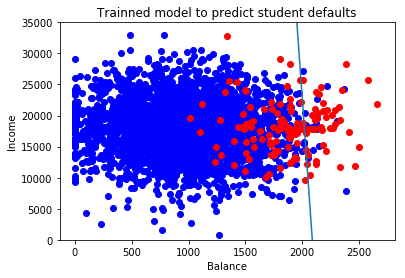

In [8]:
X = sdf[["balance","income"]]
y = sdf["default"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 666)

model = LogisticRegression(penalty = "l1")
fit = model.fit(X_train,y_train)

plt.scatter(sdf.balance[sdf['default']==0], sdf.income[sdf['default']==0],c='blue')
plt.scatter(sdf.balance[sdf['default']==1], sdf.income[sdf['default']==1],c='red')
plt.title("Trainned model to predict student defaults")
plt.xlabel("Balance")
plt.ylabel("Income")

b = fit.intercept_
coef = fit.coef_[0]

x = np.arange(0, 2600, 1)
y = (b + coef[0] * x) / (-coef[1])
plt.plot(x, y)
plt.ylim(0, 35000)
plt.show()

Text(0.5,1,'ROC fold (AUC = 0.94)')

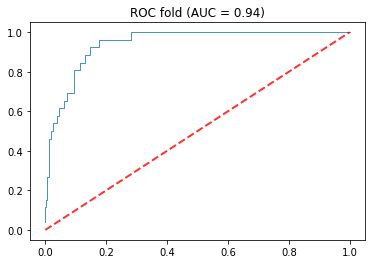

In [9]:
def get_auc(X,y,fit):
    probas_ = fit.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,fit)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC fold (AUC = %0.2f)' % (roc_auc))

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Best alpha is 0.1


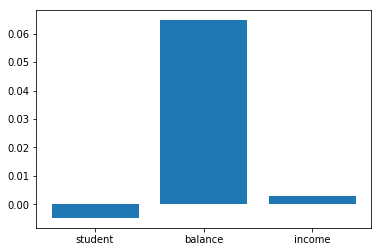

The coefficients are: [-0.00483573  0.06472572  0.00296429]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
X = df[["student","balance","income"]]
y = df["default"]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#X_scaled = preprocessing.scale(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 10)

# Construct alphas that we used in Ridge regularization
alphas = np.logspace(-5, -1, 1000)
scores = []

for alpha in alphas:
    regr = Ridge(alpha=alpha) # Ridge regularization definitaion
    regr.fit(X_train, y_train) # Fit tranning data
    scores.append((regr.score(X_test,y_test))) # Append score to the scores list

best_alpha = alphas[np.argmax(scores)]
print("Best alpha is %s" % best_alpha)

regr = Ridge(alpha = best_alpha)
regr.fit(X_train, y_train)

name_list = ['student','balance','income']  
fig = plt.figure()
plt.bar(range(len(regr.coef_)), regr.coef_, tick_label=name_list)    
plt.show()
print ('The coefficients are:',regr.coef_)

model = LogisticRegression(penalty='l1', C= best_alpha)
lreg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Text(0.5,1,'ROC fold (AUC = 0.93)')

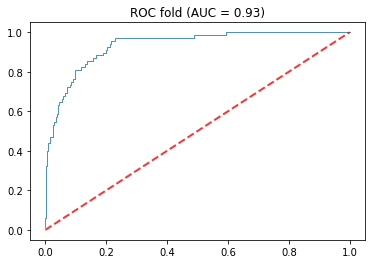

In [11]:
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,lreg)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC fold (AUC = %0.2f)' % (roc_auc))

The performance has no significant increase.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [12]:
lcr = cross_val_score(lreg, X, y, cv=10)
print(lcr)

[0.97002997 0.97502498 0.97202797 0.971      0.971      0.974
 0.97       0.97497497 0.97797798 0.97197197]


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [13]:
from sklearn import tree
import graphviz 

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 10)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

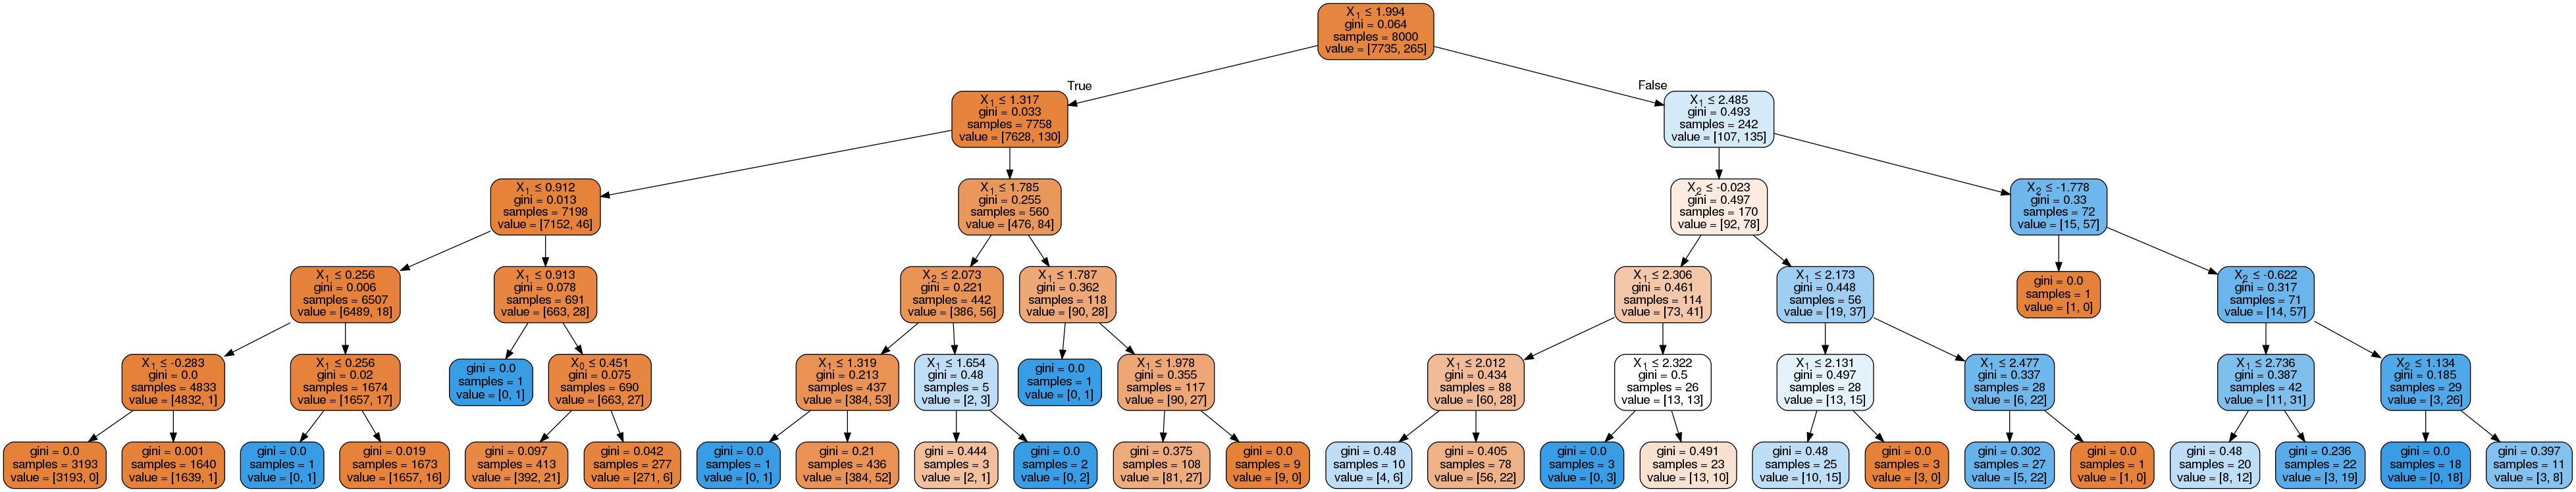

In [14]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

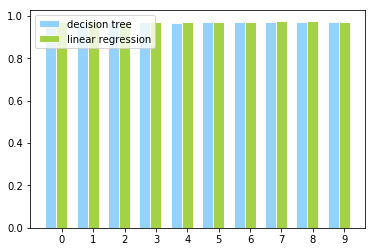

In [15]:
dcr=cross_val_score(clf, X, y, cv=10)

xr = np.arange(10)+1
name_list = range(10) 
fig = plt.figure()
plt.bar(xr, dcr, tick_label=name_list, alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white', label='decision tree', lw=1)
plt.bar(xr+0.35, lcr, tick_label=name_list, alpha=0.9, width = 0.35, facecolor = 'yellowgreen', edgecolor = 'white', label='linear regression', lw=1)

plt.legend(loc="upper left") 
plt.show()

The comparison between decision tree and linear regression approaches is shown above.

8) Find the optimal decision tree depth and compute the AUC ROC. 

The optimal depth is 3


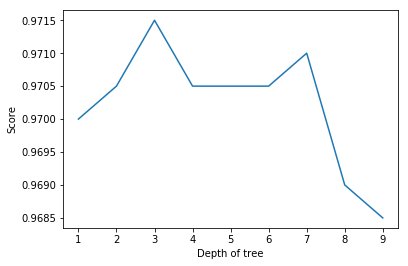

In [18]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    d_tree = tree.DecisionTreeClassifier(max_depth=n)
    d_tree.fit(X_train, y_train)
    scores.append(d_tree.score(X_test,y_test))    

    
plt.ylabel('Score')
plt.xlabel('Depth of tree')
plt.plot(depths,scores)
test_errors = scores
optimal_depth = depths[np.argmax(scores)]
print('The optimal depth is %d' %(optimal_depth))
plt.show()

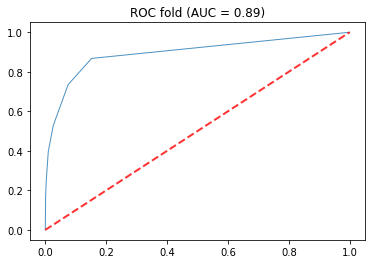

In [19]:
odt = tree.DecisionTreeClassifier(max_depth=optimal_depth)
odt.fit(X_train, y_train)
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,odt)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC fold (AUC = %0.2f)' % (roc_auc))
plt.show()